# Data Collection and Analysis of Movie Data
### Authors: Jan Hanzal, Eric Zila

In the first place, necessary imports are made.

Packages:
* package `copy` used for safe data manipulation
* package `matplotlib.pyplot` used for plotting
* package `pandas` used for data frame manipulation
* package `re` used for operations with regular expressions
* package `requests` used for communication with HTTP servers
* package `statsmodels` used for data analysis

Classes:
* class `BeautifulSoup` from package `bs4` used for scraping

In [78]:
import ast
import copy
import matplotlib.pyplot as plt
import pandas as pd
import re
import requests
import statsmodels.api as sm

from bs4 import BeautifulSoup

When downloading data about movies from IMDb, it is necessary to have an object at hand that is capable of storing these pieces of information in an organized manner. To do so, we have decided to create a separate class that accepts downloaded data pieces as parameters and stores them as instance variables.

In [3]:
"""
Encapsulates information about a movie.
"""
class Movie:
    """
    Initiates Movie class.
    
    @param title -> title of the movie
    @param original_title -> original title of the movie
    @param worldwide_gross -> worldwide gross of the movie
    @param rating -> rating of the movie
    @param rating_count -> total number of ratings of the movie
    @param runtime -> total length of the movie
    @param director -> director of the movie
    @param release_date -> release date of the movie
    @param genres -> genres of the movie
    @param countries -> countries of the movie
    @param languages -> languages of the movie
    @param budget -> budget of the movie
    """
    def __init__(self, title, original_title, worldwide_gross, rating, 
                 rating_count, runtime, director, release_date, genres,
                 countries, languages, budget):
        self.title = title
        self.original_title = original_title
        self.worldwide_gross = worldwide_gross
        self.rating = rating
        self.rating_count = rating_count
        self.runtime = runtime
        self.director = director
        self.release_date = release_date
        self.genres = genres
        self.countries = countries
        self.languages = languages
        self.budget = budget
        
    """
    Builds a string containing all available information about the movie.
    
    @return String object containing all information
    """
    def to_string(self):
        string = f"title: {self.title}\n"
        
        if self.original_title is not None:
            string += f"original title: {self.original_title}\n"
            
        if self.worldwide_gross is not None:
            string += f"worldwide gross: {self.worldwide_gross}\n"
        
        if self.rating is not None:
            string += f"rating: {self.rating}\n"
        
        if self.rating_count is not None:
            string += f"rating count: {self.rating_count}\n"
        
        if self.runtime is not None:
            string += f"runtime: {self.runtime}\n"
        
        if self.director is not None:
            string += f"director: {self.director}\n"
        
        if self.release_date is not None:
            string += f"release date: {self.release_date}\n" 
            
        if self.genres is not None:
            string += f"genres: "
            for genre in self.genres:
                string += genre + " "
            string += "\n"
            
        if self.countries is not None:
            string += "countries: "
            for country in self.countries:
                string += country + " "
            string += "\n"
        
        if self.languages is not None:
            string += "languages: "
            for language in self.languages:
                string += language + " "
            string += "\n"
            
        if self.budget is not None:
            string += "budget: " + self.budget + "\n"
        
        return string
    
    """
    Builds a dictionary containing all available information about the movie.
    
    @return Dictionary object containing all information
    """    
    def to_dict(self):
        return {'title' : self.title,
                'original_title' : self.original_title,
                'worldwide_gross' : self.worldwide_gross,
                'rating' : self.rating,
                'rating_count' : self.rating_count,
                'runtime' : self.runtime,
                'director' : self.director,
                'release_date' : self.release_date,
                'genres' : self.genres,
                'countries' : self.countries,
                'languages' : self.languages,
                'budget' : self.budget}

Our IMDb downloader class expects a link to an IMDb list page when initialized. If it is given such link, it is capable of going through and downloading information about every movie listed. Of course, it follows up on this task by downloading information about every movie on further pages as well. It can be given a limit of how many further pages should movie information be downloaded from.

In [4]:
"""
Downloader of movie data starting from an IMDb list page.
"""
class ImdbDownloader:
    """
    Initiates ImdbDownloader class.
    
    @param link -> link to the first IMDb list page to be downloaded from
    """
    def __init__(self, link):
        self.original_link = link # original link passed to the downloader
        self.movies = []
    
    """
    Controls the downloading process.
    
    @param pages -> number of pages to be downloaded, if not defined, all pages are downloaded
    """
    def start(self, pages=-1):
        cont = True # used for indication of reaching the last page
        count = 0 # counter of the number of movies downloaded
        chunk = 1000 # number of movies to be added to the csv file and deleted from RAM
        cur_link = self.original_link # link to a website that is currently downloaded from
        
        while cont and pages != 0:
            cur_soup = self.get_soup(cur_link)
            ls = ImdbListScraper(cur_soup)
            cur_movie_links = ls.get_movie_links()
            
            for cur_movie_link in cur_movie_links:
                cur_movie_soup = self.get_soup(cur_movie_link)
                ms = ImdbMovieScraper(cur_movie_soup)
                
                title = ms.get_title()
                original_title = ms.get_original_title()
                worldwide_gross = ms.get_worldwide_gross()
                rating = ms.get_rating()
                rating_count = ms.get_rating_count()
                runtime = ms.get_runtime()
                director = ms.get_director()
                release_date = ms.get_release_date()
                genres = ms.get_genres()
                countries = ms.get_countries()
                languages = ms.get_languages()
                budget = ms.get_budget()
                
                movie = Movie(title, original_title, worldwide_gross, rating, 
                              rating_count, runtime, director, release_date,
                              genres, countries, languages, budget)
                self.movies.append(movie)
                
                count += 1
                if (count % 250) == 0 :
                    print(f"We have downloaded {str(count)} movies so far!")
                    
                if (count % chunk) == 0:
                    if (count != chunk):
                        self.append_csv()
                    else:
                        self.create_csv()

            cur_link = ls.get_next_page_link()
            if cur_link is None:
                cont = False
                
            pages = pages - 1
        
        if count < chunk:
            self.create_csv()
        else:
            self.append_csv()
    
    """
    Obtains the soup of a web page.
    
    @param link -> link to the web page a soup should be downloaded from
    
    @return BeautifulSoup object containing requested soup
    """
    def get_soup(self, link):
        request = requests.get(link)
        request.encoding = 'UTF-8'
        soup = BeautifulSoup(request.text)
        
        return soup
    
    """
    Creates a new csv file and saves data to it.
    """
    def create_csv(self):
        print(f"About to create a data file and add {str(len(self.movies))} movies to it!\n")
        
        df = pd.DataFrame.from_records([movie.to_dict() for movie in self.movies])
        
        df.to_csv('data.csv', index=False)
                
        self.movies = []
    
    """
    Saves data to the end of a csv file.
    """
    def append_csv(self):
        print(f"About to append {str(len(self.movies))} movies to the data file!\n")
        
        df = pd.DataFrame.from_records([movie.to_dict() for movie in self.movies])
        
        df.to_csv('data.csv', mode='a', index=False, header=False)
                
        self.movies = []
    
    """
    Prints information about all movies that were scraped so far.
    """
    def print_movies(self):
        print("\nAbout to print " + str(len(self.movies)) + " movies!\n")
        
        for movie in self.movies:
            print(movie.to_string())

In [5]:
"""
Scraper of information from an IMDb list page.
"""
class ImdbListScraper:
    """
    Initiates ImdbListScraper class.
    
    @param soup -> soup of an IMDb list page to be scraped
    """
    def __init__(self, soup):
        self.soup = soup
        
    """
    Obtains all movie links from an IMDb list soup.
    
    @return List object containing movie links
    """
    def get_movie_links(self):
        movies = self.soup.find_all('img', {'class':'loadlate'})
        links = ['https://www.imdb.com' + movie.parent['href'] for movie in movies]
        
        return links
    
    """
    Obtains a link to the next page from an IMDb list soup.
    
    @return String object containing link to the next page, None object if not found
    """
    def get_next_page_link(self):
        next_page = self.soup.find('a', {'class':'lister-page-next next-page'})
        
        if next_page is not None:
            return 'https://www.imdb.com' + next_page['href']
        else:
            return None

In [6]:
"""
Scraper of information from an IMDb movie page.
"""
class ImdbMovieScraper:
    """
    Initiates ImdbMovieScraper class.
    
    @param soup -> soup of an IMDb movie page to be scraped
    """
    def __init__(self, soup):
        self.soup = soup
        
    """
    Obtains the title of a movie on an IMDb movie page.
    
    @return String object containing title of a movie
    """
    def get_title(self):
        title = self.soup.find('div', {'class':'title_wrapper'})
        
        return title.h1.find(text=True, recursive=False)
    
    """
    Obtains the original title of a movie on an IMDb movie page.
    
    @return String object containing original title of a movie, None object if not found
    """
    def get_original_title(self):
        original_title = self.soup.find('div', {'class':'originalTitle'})
        
        if original_title is not None:
            return original_title.find(text=True, recursive=False)
        else:
            return None
        
    """
    Obtains the worldwide gross of a movie on an IMDb movie page.
    
    @return String object containing worldwide gross of a movie, None object if not found
    """
    def get_worldwide_gross(self):
        worldwide_gross = self.soup.find('h4', text='Cumulative Worldwide Gross:')
        
        if worldwide_gross is not None:
            return re.sub("[^0-9]", "", worldwide_gross.parent.text)
        else:
            return None
        
    """
    Obtains the rating of a movie on an IMDb movie page.
    
    @return String object containing rating of a movie
    """
    def get_rating(self):
        rating = self.soup.find('span', {'itemprop':'ratingValue'})
        
        return rating.text
    
    """
    Obtains the total number of ratings of a movie on an IMDb movie page.
    
    @return String object containing the number of ratings of a movie
    """
    def get_rating_count(self):
        rating_count = self.soup.find('span', {'class':'small', 'itemprop':'ratingCount'})
        
        return rating_count.text
    
    """
    Obtains the runtime of a movie on an IMDb movie page.
    
    @return String object containing the runtime of a movie
    """
    def get_runtime(self):
        runtime = self.soup.find('div', {'class':'subtext'})
        
        try:
            return re.sub("[^0-9]", "", runtime.time['datetime'])
        except:
            return None
    
    """
    Obtains the director of a movie on an IMDb movie page.
    
    @return String object containing the director of a movie, None object if not found
    """
    def get_director(self):
        director = self.soup.find('h4', text='Director:')
        
        if director is not None:
            return director.parent.a.text
        else:
            return None
        
    """
    Obtains the release date of a movie on an IMDb movie page.
    
    @return String object containing the release date of a movie, None object if not found
    """
    def get_release_date(self):
        release_date = self.soup.find('a', {'title':'See more release dates'})
        
        if release_date is not None:
            return re.sub("\n", "", release_date.text)
        else:
            return None
    
    """
    Obtains the genres of a movie on an IMDb movie page.
    
    @return List object containing genres of a movie, None object if not found
    """
    def get_genres(self):
        genres = self.soup.find('h4', text='Genres:')
        
        if genres is not None:
            return [re.sub(" ", "", genre.text) for genre in genres.parent.find_all('a')]
        else:
            return None
        
    """
    Obtains the countries of a movie on an IMDb movie page.
    
    @return List object containing countries of a movie, None object if not found
    """
    def get_countries(self):
        countries = self.soup.find('h4', text='Country:')
        
        if countries is not None:
            return [country.text for country in countries.parent.find_all('a')]
        else:
            return None
        
    """
    Obtains the languages of a movie on an IMDb movie page.
    
    @return List object containing languages of a movie, None object if not found
    """
    def get_languages(self):
        languages = self.soup.find('h4', text='Language:')
        
        if languages is not None:
            return [language.text for language in languages.parent.find_all('a')]
        else:
            return None
        
    """
    Obtains the budget of a movie on an IMDb movie page.
    
    @return String object containing budget of a movie, None object if not found
    """
    def get_budget(self):
        budget = self.soup.find('h4', text='Budget:')
        
        if budget is not None:
            return re.sub("[^0-9]", "", budget.parent.text)
        else:
            return None

The following class uses the data downloaded in the form of the 'Movies' class and transforms them into a pandas dataframe. It further has the functionality of filtering the dataframe based on several parameters for easy access to modified dataframes.

In [7]:
"""
Stores the scraped data in a pandas dataframe.
For easier handling, includes several filtering methods.
Later on, more methods will be added when needed.
"""
class MovieDataFrame:
    """
    Initiates MovieDataFrame class.
    
    @param data -> instance of a downloader object of an IMDb movie page
    """
    def __init__(self, downloader=None, csv_path=None):
        self.downloader = downloader
        self.csv_path = csv_path
        if downloader is not None:
            self.data = self.downloader.movies
            self.df = self.from_movies_to_data_frame()
        elif csv_path is not None:
            self.df = self.from_csv_to_data_frame()
        else:
            raise Exception("Data source needs to be specified.")
            

    """
    Converts movie dictionaries into a data frame.
    
    @return Pandas data frame object with every movie contained in a given downloader instance
    """  
    def from_movies_to_data_frame(self):
        return pd.DataFrame.from_records([movie.to_dict() for movie in self.data])
    
    """
    Converts csv into a data frame.
    
    @return Pandas data frame object with every movie contained in a csv
    """  
    def from_csv_to_data_frame(self):
        return pd.read_csv(self.csv_path)   
    
    """
    Converts columns into right types.
    
    @return Pandas data frame object with converted data types.

    """
    def convert_columns(self):
        self.df['release_date'] = self.df['release_date'].astype('str')
        self.df['release_date'] = self.df['release_date'].apply(lambda x: re.findall('[0-9]+ [A-Z][a-z]+ [0-9]+', x)).str[0]
        self.df['release_date'] = pd.to_datetime(self.df['release_date'], format='%d %B %Y', errors='coerce')
        for column in ['budget', 'worldwide_gross', 'rating', 'runtime', 'rating_count']:
            self.df[column] = pd.to_numeric(self.df[column],errors='coerce')
        return self
    
    """
    Filters data frame based on a column of lists

    @return Pandas data frame, filtered
    """  
    def filter_df_list(self, column, element, in_place):
        mask = self.df[column].apply(lambda x: element in x)
        self.df = self.df.loc[mask,:]
        if in_place:
            return self
        else:
            return self.df

    """
    Filters data frame based on a column of strings

    @return Pandas data frame, filtered
    """      
    def filter_df_string(self, column, element, in_place):
        self.df = self.df.loc[self.df[column] == element,:]
        if in_place:
            return self
        else:
            return self.df

    """
    Transforms a column into floats if possible. Filters data frame based on a column of floats.

    @return Pandas data frame, filtered
    """      
    def filter_df_float(self, column, higher_than, lower_than, equal_to, in_place):
        self.df[column] = pd.to_numeric(self.df[column])
        if equal_to is None:
            if higher_than is not None:
                self.df = self.df.loc[self.df[column] > higher_than,:]
            if lower_than is not None:
                self.df = self.df.loc[self.df[column] < lower_than,:]
        else:
            self.df = self.df.loc[self.df[column] == equal_to,:]
        if in_place:
            return self
        else:
            return self.df

    """
    Following methods filter data frame based on the indicated column using above methods.
    Can be easily chained.

    @return Pandas data frame, filtered
    """              
    def filter_genre(self, genre, in_place=True):
        return self.filter_df_list('genres', genre, in_place)   

    def filter_country(self, country, in_place=True):
        return self.filter_df_list('countries', country, in_place) 

    def filter_language(self, language, in_place=True):
        return self.filter_df_list('languages', language, in_place)   

    def filter_director(self, director, in_place=True):
        return self.filter_df_string('director', director, in_place)  

    def filter_budget(self, max_budget=None, min_budget=None, exact_budget=None, in_place=True):
        return self.filter_df_float('budget', higher_than=max_budget, lower_than=min_budget,
                                    equal_to=exact_budget, in_place=in_place)    

    def filter_rating(self, max_rating=None, min_rating=None, exact_rating=None, in_place=True):
        return self.filter_df_float('rating', higher_than=max_rating, lower_than=min_rating, 
                                    equal_to=exact_rating, in_place=in_place)

    def filter_runtime(self, max_runtime=None, min_runtime=None, exact_runtime=None, in_place=True):
        return self.filter_df_float('runtime', higher_than=max_runtime, lower_than=min_runtime, 
                                    equal_to=exact_runtime, in_place=in_place)

    def filter_gross(self, max_gross=None, min_gros=None, exact_gross=None, in_place=True):
        return self.filter_df_float('worldwide_gross', higher_than=max_gross, lower_than=min_gros, 
                                    equal_to=exact_gross, in_place=in_place)

To show what our program is currently capable of, we let it run through a list of feature films and tv movies having ratings from at least 100,000 users on IMDb. First, let's show the output of downloading the first two pages and printing the content of every single movie downloaded.

In [8]:
imdb1 = ImdbDownloader('https://www.imdb.com/search/title/?title_type=feature,tv_movie&num_votes=1000,&sort=release_date,desc&view=simple')
imdb1.start()

KeyboardInterrupt: 

Here we start with our analysis. Let's first load the data from the .csv file 
we prepared earlier.

In [91]:
df = pd.read_csv(r'data/data.csv')

In [90]:
df_obj = MovieDataFrame(csv_path='data/data.csv')
df_obj.convert_columns()

First, we will have a look at the influence of the movie genre on how the movie performed worldwide (measured by the gross amount of revenue it made). Let us plot the mean worldwide gross for a few main genres as a function of time.

In [94]:
genres = ['Action', 'Comedy','Drama', 'Romance', 'Thriller']
first = True
for genre in genres:
    #we need to make a copy every time, else we would be filtering an already filtered df
    df_genre = copy.copy(df_obj)
    df_genre = df_genre.filter_genre(genre, in_place=False)
    df_genre_time = df_genre[['worldwide_gross','release_date']].dropna()
    df_genre_time = df_genre_time.set_index('release_date')
    #resample with a yearly frequency while applying the mean function
    df_genre_time = df_genre_time.resample('Y').mean()
    df_genre_time.columns = [name + '_' + genre for name in df_genre_time.columns]
    if first:
        #create the df if this is the first pass in the loop
        ts_df = df_genre_time
        first = False
    else:
        #join a new genre time series to the df if this is not the first pass in the loop
        ts_df = ts_df.join(df_genre_time, how='outer')

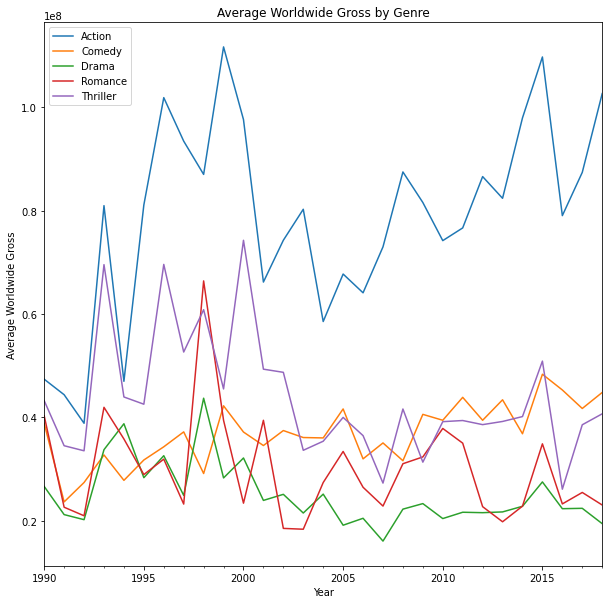

In [95]:
ts_df = ts_df.loc['1990-01-01':'2019-01-01']
ts_df.plot()
plt.xlabel('Year')
plt.ylabel('Average Worldwide Gross')
plt.title('Average Worldwide Gross by Genre')
plt.legend(['Action', 'Comedy', 'Drama', 'Romance', 'Thriller'])
plt.rcParams["figure.figsize"] = (10,10)
plt.show()

We can see that the action movie category has by far the largest box office, with the difference getting only bigger over time. What is also quite notable is the decline of thrillers and the rise of comedies.

Now let's make a simple linear model summarizing the effect of genre on the worldwide profit. Note that a film typically has several genres, therefore their effects have to be added together in the individual cases.

In [96]:
model_data = df_obj.df
film_endog = model_data.loc[:,'worldwide_gross']
genres = model_data.loc[:,'genres']
#create a dummy variable data frame containing info on movie genre
unique = []
for row in genres:
    #row looks like a list, but it is a string => we need to convert it
    row = ast.literal_eval(row)
    for element in row:
        unique.append(element)
unique = set(unique)
genres_data_dict = {genre: genres.apply(lambda x: int(genre in x)) for genre in unique}
film_genre_exog = pd.DataFrame.from_dict(genres_data_dict)
#statsmodels linear regression, we do not include an intercept since we want to avoid 
#perfect multicollinearity
model = sm.OLS(film_endog, film_genre_exog, missing='drop')
results = model.fit()
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:        worldwide_gross   R-squared (uncentered):                   0.204
Model:                            OLS   Adj. R-squared (uncentered):              0.203
Method:                 Least Squares   F-statistic:                              215.3
Date:                Thu, 04 Jun 2020   Prob (F-statistic):                        0.00
Time:                        15:44:56   Log-Likelihood:                     -3.6763e+05
No. Observations:               18467   AIC:                                  7.353e+05
Df Residuals:                   18445   BIC:                                  7.355e+05
Df Model:                          22                                                  
Covariance Type:            nonrobust                                                  
                  coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------

Considering that we included only information on movie genre, the model fit is quite decent (with an R-squared of 0.13). Even though the model is simplistic and it would be unwise to do any causal inference with it, we can easily spot the correlation between different movie genres and the worldwide gross revenue they made, which was our goal.